In [17]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4461771675555814453, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 8456119255
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4681023329196228465
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [1]:
import os
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os.path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy

In [12]:
print("Torch Version",torch.__version__)

Torch Version 0.4.1


In [2]:
main_dir = "data"
data_dir = os.path.join(main_dir, "Wheat")
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [10]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(valid_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data\Wheat\train 0
data\Wheat\train\loged 3360
data\Wheat\train\Nonloged 6240
******************************
data\Wheat\valid 0
data\Wheat\valid\loged 848
data\Wheat\valid\Nonloged 1552
******************************
data\Wheat\test 0
data\Wheat\test\loged 64
data\Wheat\test\Nonloged 122


In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [4]:
dataset_mean = [0.485, 0.456, 0.406]
dataset_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.RandomRotation(10, expand=True),
#                                       transforms.CenterCrop(224),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

test_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.Grayscale(num_output_channels=3),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

train_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

valid_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

test_dataset =  torchvision.datasets.ImageFolder(test_dir,
                                                transform=test_transform)

batch_size = 32
dataloaders = {}

dataloaders["train"] = torch.utils.data.DataLoader(train_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["valid"] = torch.utils.data.DataLoader(valid_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["test"] = torch.utils.data.DataLoader(test_dataset,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  num_workers=1)

dataset_sizes = {"train": len(train_dataset), 
                 "valid":len(valid_dataset),
                 "test":len(test_dataset)}

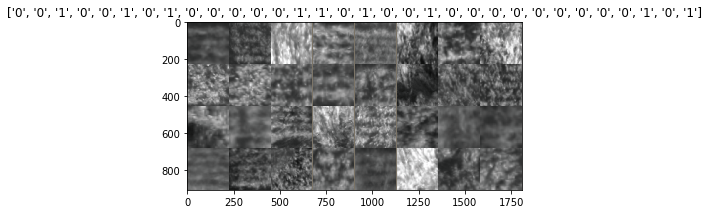

In [5]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[str(x.item()) for x in classes])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
print(dataset_sizes)
print(device)

{'train': 9600, 'valid': 9600, 'test': 186}
cuda:0


In [7]:
# Building the network
model_ft = torchvision.models.resnet18(pretrained=False)

# pretrained=True
# if pretrained:
#     model_ft.load_state_dict(torch.load('../input/pretrained-pytorch-models/resnet18-5c106cde.pth'))
#     model_ft = torchvision.models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
fc = torch.nn.Sequential(nn.Linear(512, 512),
                         nn.Dropout(0.2),
                         nn.ReLU(),
                         nn.Linear(512, 2))
model_ft.fc = fc
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(fc.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(fc.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft,
#                                              step_size=10,
#                                              gamma=0.9)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
#         print(".", end="", sep="")
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 print(".", end="")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler=None, num_epochs=50)

Epoch 0/49
--------------------
train Loss: 0.5031 Acc: 0.7590
valid Loss: 0.4582 Acc: 0.7931

Epoch 1/49
--------------------
train Loss: 0.4746 Acc: 0.7780
valid Loss: 0.4535 Acc: 0.7899

Epoch 2/49
--------------------
train Loss: 0.4605 Acc: 0.7871
valid Loss: 0.4498 Acc: 0.8061

Epoch 3/49
--------------------
train Loss: 0.4609 Acc: 0.7900
valid Loss: 0.4280 Acc: 0.8116

Epoch 4/49
--------------------
train Loss: 0.4526 Acc: 0.7907
valid Loss: 0.4190 Acc: 0.8139

Epoch 5/49
--------------------
train Loss: 0.4469 Acc: 0.7995
valid Loss: 0.4236 Acc: 0.8108

Epoch 6/49
--------------------
train Loss: 0.4488 Acc: 0.7959
valid Loss: 0.4292 Acc: 0.8155

Epoch 7/49
--------------------
train Loss: 0.4439 Acc: 0.8022
valid Loss: 0.4411 Acc: 0.7971

Epoch 8/49
--------------------
train Loss: 0.4351 Acc: 0.8039
valid Loss: 0.4199 Acc: 0.8180

Epoch 9/49
--------------------
train Loss: 0.4399 Acc: 0.8003
valid Loss: 0.4145 Acc: 0.8168

Epoch 10/49
--------------------
train Loss: 0.440

In [61]:
torch.save(model_ft.state_dict(), "models/01.wheat_resnet18.pth")

In [44]:
correct = 0
total = 0
loss = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels)
        
        y_pred += predicted.to("cpu").detach().numpy().tolist()
        y_true += labels.to("cpu").detach().numpy().tolist()
        
print('Test accuracy: {:.4f}' .format( 100 * correct / total))
print('Test Loss: %.4f'%(test_loss))

Test accuracy: 85.4839
Test Loss: 0.2895


In [45]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[116   6]
 [ 21  43]]


In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
classnames=[]
for classname in dataloaders["test"]:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_true, y_pred) 
print(confusion_mtx)
target_names = classnames
# print(classification_report(y_true, y_pred, target_names=target_names))
print(classification_report(y_true, y_pred))

[[116   6]
 [ 21  43]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       122
           1       0.88      0.67      0.76        64

   micro avg       0.85      0.85      0.85       186
   macro avg       0.86      0.81      0.83       186
weighted avg       0.86      0.85      0.85       186



In [56]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  85.48387096774194
Sensitivity :  84.67153284671532
Specificity :  87.75510204081633


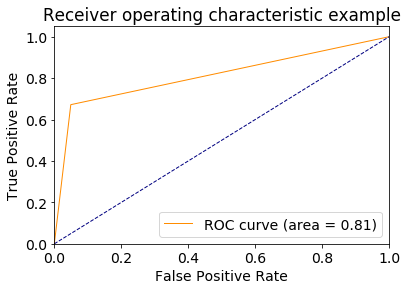

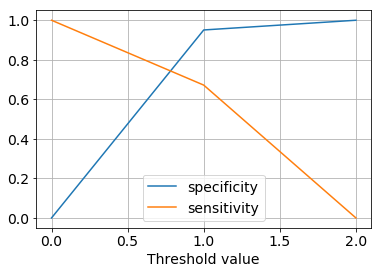

In [55]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

Confusion Matrix
[[116   6]
 [ 21  43]]


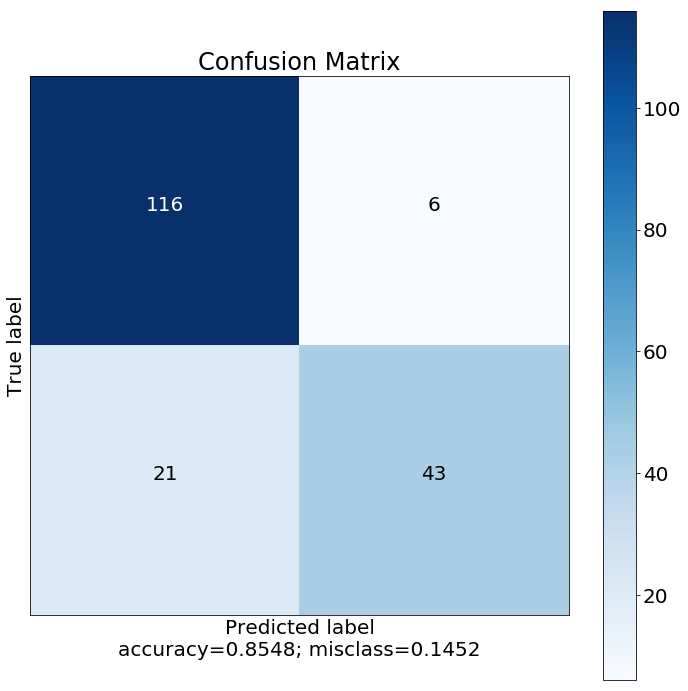

In [48]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

   
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [ ]:
cm = np.array(cm)

    precisions = []
    recalls = []
    for i in range(len(cm)):
        precisions.append(cm[i][i] / sum(cm[:, i].tolist()))
        recalls.append(cm[i][i] / sum(cm[i, :].tolist()))

    print('Precision List: ')
    print(precisions)
    print('Recall List: ')
print(recalls)

In [15]:
# To view which layers are freeze and which layers are not freezed:
for name, child in model_ft.named_children():
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)

weight False
weight False
bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0.downsample.0.weight False
0.downsample.1.weight False
0.downsample.1.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0.downsample.0.weight False
0.downsample.1.weight False
0.downsample.1.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0